In [20]:
import os
import os.path as op
import sys

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

#from bluemath_tk.wrappers.swash.swash_wrapper import SwashModelWrapper
#from IPython.display import HTML

from scripts.wrappers import SwashModelWrapper_ondas

from scripts.bathymetry import linear_profile
from scripts.plots import plot_case_config

## 01.Define Case Variables

#### Necessary Paths

In [21]:
templates_dir = '/workspaces/ONDAS_Swash/templates'
output_dir = '/workspaces/ONDAS_Swash/cases'

#### Hydrodynamic Forcing

In [46]:
Hs = 5.0
Tp = 20
Hs_L0 =  round((2 * np.pi * (Hs)) / (9.81 * (Tp ** 2)),4)  # Should be between 0.005 and 0.05
WL = 0.0

In [47]:
Hs_L0

0.008

#### Create Bathymetry

In [ ]:
h0 = -12  # offshore depth (m)
Ltotal = 1000  # beach heigh (m)
m = 10 / 300  # profile slope
Wfore = 400  # flume length before fore toe (m)

x_profile, depth_array = linear_profile(h0=h0, Ltotal=Ltotal, Wconst=Wfore, slope=m)

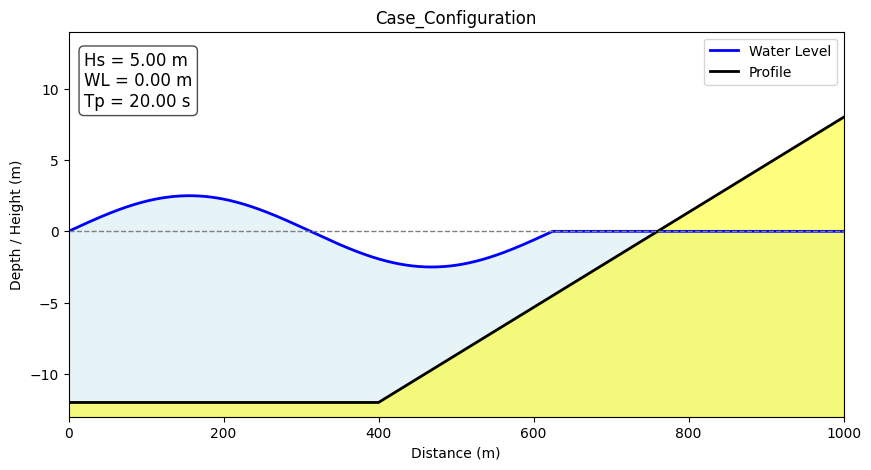

In [49]:
plot_case_config(x=x_profile, z=depth_array, wave_height=Hs, wave_period = Tp, WL=WL)

In [50]:
metamodel_parameters = pd.DataFrame({'Hs': Hs, 'Hs_L0': Hs_L0, 'WL': WL}, index=[0]).to_dict(orient='list')
fixed_parameters = {
    "dxinp": 1,  # bathymetry grid spacing  # Friction manning coefficient (m^-1/3 s)
    "comptime": 300,  # Simulation duration (s)
    "warmup": 300,  # Warmup duration (s)
    "n_nodes_per_wavelength": 60,  # number of nodes per wavelength
}

swash_model = SwashModelWrapper_ondas(
    templates_dir=templates_dir,
    metamodel_parameters=metamodel_parameters,
    fixed_parameters=fixed_parameters,
    output_dir=output_dir,
    depth_array=-depth_array,
)

In [51]:
swash_model.build_cases()

In [52]:
swash_model.run_cases(launcher='serial')

In [53]:
vars_to_postprocess = ["Msetup", "Hrms", "Hfreqs"]
postprocessed = swash_model.postprocess_cases(output_vars=vars_to_postprocess).isel(case_num=0)

In [54]:
postprocessed

<xarray.Dataset> Size: 56kB
Dimensions:   (Xp: 1001)
Coordinates:
  * Xp        (Xp) int64 8kB 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
    Yp        int64 8B 0
    case_num  int64 8B 0
Data variables:
    Msetup    (Xp) float64 8kB 0.2041 0.2033 0.2007 0.1966 ... 7.933 7.966 7.983
    Hrms      (Xp) float64 8kB 5.094 5.091 5.08 ... 0.0 2.512e-15 2.512e-15
    Hs        (Xp) float64 8kB 7.188 7.181 7.162 ... 9.73e-15 9.73e-15 9.73e-15
    Hss       (Xp) float64 8kB 7.172 7.166 7.146 ... 3.529e-18 3.529e-18
    ig        (Xp) float64 8kB 0.4645 0.465 0.4656 ... 9.73e-15 9.73e-15
    Hvlf      (Xp) float64 8kB 0.159 0.1599 0.1613 ... 9.108e-15 9.108e-15

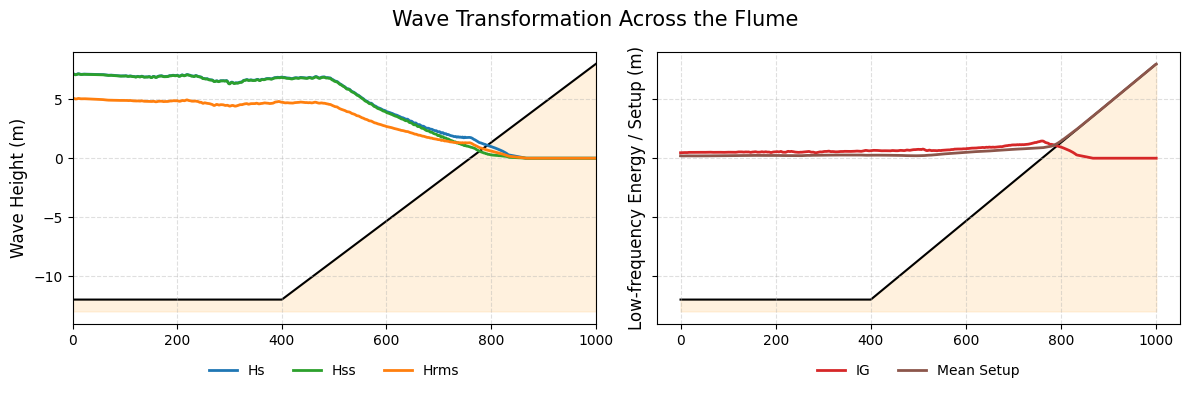

In [68]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)

ax1 = axs[0]
ax1.plot(postprocessed.Xp, postprocessed.Hs, label='Hs', color='tab:blue', lw=2)
ax1.plot(postprocessed.Xp, postprocessed.Hss, label='Hss', color='tab:green', lw=2)
ax1.plot(postprocessed.Xp, postprocessed.Hrms, label='Hrms', color='tab:orange', lw=2)

ax1.fill_between(np.arange(0, len(depth_array)), depth_array, np.min(depth_array)-1,
                 color='navajowhite', alpha=0.4, zorder=0)
ax1.plot(np.arange(0, len(depth_array)), depth_array, color='k', lw=1.5, zorder=1)

ax1.set_ylabel('Wave Height (m)', fontsize=12)
ax1.grid(True, ls='--', alpha=0.4)
ax1.legend(loc='upper right', fontsize=10, ncol=2, frameon=True)

ax2 = axs[1]
ax2.plot(postprocessed.Xp, postprocessed.ig, label='IG', color='tab:red', lw=2)
ax2.plot(postprocessed.Xp, postprocessed.Msetup, label='Mean Setup', color='tab:brown', lw=2)

ax2.fill_between(np.arange(0, len(depth_array)), depth_array, np.min(depth_array)-1,
                 color='navajowhite', alpha=0.4, zorder=0)
ax2.plot(np.arange(0, len(depth_array)), depth_array, color='k', lw=1.5, zorder=1)

ax2.set_ylabel('Low-frequency Energy / Setup (m)', fontsize=12)
ax2.grid(True, ls='--', alpha=0.4)
ax2.legend(loc='upper right', fontsize=10, ncol=2, frameon=True)

axs[0].set_xlim([np.min(postprocessed.Xp), np.max(postprocessed.Xp)])

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
           ncol=3, fontsize=10, frameon=False)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
           ncol=2, fontsize=10, frameon=False)

fig.suptitle('Wave Transformation Across the Flume', fontsize=15)

plt.tight_layout()
plt.show()
